<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week6/RNN-PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import seaborn as sns
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [7]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


In [9]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [10]:
# Load data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)

if response.status_code == 200:
    try:
        # Try to read as newline-delimited JSON
        df = pd.read_json(url, lines=True)
    except ValueError:
        # If that fails, try to read as a list of dictionaries
        data = json.loads(response.text)
        df = pd.DataFrame(data)
else:
    print("Failed to download data, check URL or internet connection.")

print("Data shape:", df.shape)
print("\nSample data:")
print(df.head())


Data shape: (26709, 3)

Sample data:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [13]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
article_link    0
headline        0
is_sarcastic    0
dtype: int64


In [14]:
# Check class distribution
print("\nClass distribution:")
print(df['is_sarcastic'].value_counts())



Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


In [16]:
# Preprocess text data
def preprocess_text(texts):
    tokenized_texts = [word_tokenize(text.lower()) for text in texts]
    return tokenized_texts

# Tokenize the headlines
tokenized_headlines = preprocess_text(df['headline'].values)

# Build vocabulary
word_counts = Counter()
for tokens in tokenized_headlines:
    word_counts.update(tokens)

In [17]:
# Keep only the most common words
vocab_size = 10000
vocab = ['<PAD>', '<UNK>'] + [word for word, count in word_counts.most_common(vocab_size-2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}


In [18]:
# Function to convert tokens to indices
def tokens_to_indices(tokens, word_to_idx, max_len=50):
    indices = [word_to_idx.get(token, 1) for token in tokens]  # 1 is <UNK>

    # Padding or truncating
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))  # 0 is <PAD>
    else:
        indices = indices[:max_len]

    return indices


In [19]:
# Convert all tokenized headlines to indices
max_len = 50
headline_indices = [tokens_to_indices(tokens, word_to_idx, max_len) for tokens in tokenized_headlines]


In [20]:
# Create PyTorch dataset
class SarcasmDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = indices
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)


In [21]:
# Split data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    headline_indices, df['is_sarcastic'].values,
    test_size=0.2, random_state=SEED, stratify=df['is_sarcastic'].values
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.25, random_state=SEED, stratify=y_train_val
)

In [22]:
# Create datasets
train_dataset = SarcasmDataset(X_train, y_train)
val_dataset = SarcasmDataset(X_val, y_val)
test_dataset = SarcasmDataset(X_test, y_test)


In [23]:
# Create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [24]:
# Define RNN model
class SarcasmRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)

        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text shape: [batch size, sequence length]

        embedded = self.embedding(text)
        # embedded shape: [batch size, sequence length, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output shape: [batch size, sequence length, hidden dim * num directions]

        # Use the final hidden state
        if self.rnn.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        # hidden shape: [batch size, hidden dim * num directions]

        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        # output shape: [batch size, output dim]

        return output

In [25]:
# Set model hyperparameters
INPUT_DIM = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5

In [26]:

# Initialize model
model = SarcasmRNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT)
model = model.to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'auc': auc
    }

In [28]:
# Training function
def train(model, iterator, optimizer, criterion):
    model.train()

    epoch_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    for batch in tqdm(iterator, desc="Training"):
        optimizer.zero_grad()

        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Convert predictions to numpy arrays for metric calculation
        preds = torch.sigmoid(predictions).detach().cpu().numpy()
        binary_preds = (preds > 0.5).astype(int)

        all_preds.extend(binary_preds)
        all_probs.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_preds, all_probs)

    return epoch_loss / len(iterator), metrics


In [29]:
# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating"):
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text).squeeze(1)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()

            # Convert predictions to numpy arrays for metric calculation
            preds = torch.sigmoid(predictions).cpu().numpy()
            binary_preds = (preds > 0.5).astype(int)

            all_preds.extend(binary_preds)
            all_probs.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_preds, all_probs)

    return epoch_loss / len(iterator), metrics, all_labels, all_probs, all_preds


In [30]:
# Train the model
n_epochs = 10
best_val_loss = float('inf')
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(n_epochs):
    print(f"\nEpoch {epoch+1}/{n_epochs}")

    train_loss, train_metrics = train(model, train_loader, optimizer, criterion)
    val_loss, val_metrics, _, _, _ = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_metrics['accuracy'])
    val_accs.append(val_metrics['accuracy'])

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_metrics['accuracy']:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_metrics['accuracy']:.4f}")

    # Save the best model in memory
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
        print("Best model saved in memory!")



Epoch 1/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 239.61it/s]


Train Loss: 0.4976, Train Acc: 0.7459
Val Loss: 0.4112, Val Acc: 0.8139
Best model saved in memory!

Epoch 2/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 243.30it/s]


Train Loss: 0.3458, Train Acc: 0.8500
Val Loss: 0.3644, Val Acc: 0.8399
Best model saved in memory!

Epoch 3/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 206.02it/s]


Train Loss: 0.2542, Train Acc: 0.8959
Val Loss: 0.3616, Val Acc: 0.8431
Best model saved in memory!

Epoch 4/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 242.30it/s]


Train Loss: 0.1752, Train Acc: 0.9327
Val Loss: 0.4212, Val Acc: 0.8534

Epoch 5/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 241.09it/s]


Train Loss: 0.1138, Train Acc: 0.9571
Val Loss: 0.4766, Val Acc: 0.8512

Epoch 6/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 247.65it/s]


Train Loss: 0.0717, Train Acc: 0.9748
Val Loss: 0.5338, Val Acc: 0.8545

Epoch 7/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 240.85it/s]


Train Loss: 0.0538, Train Acc: 0.9823
Val Loss: 0.6475, Val Acc: 0.8529

Epoch 8/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 215.86it/s]


Train Loss: 0.0364, Train Acc: 0.9873
Val Loss: 0.6392, Val Acc: 0.8452

Epoch 9/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 243.90it/s]


Train Loss: 0.0287, Train Acc: 0.9910
Val Loss: 0.8105, Val Acc: 0.8497

Epoch 10/10


Evaluating: 100%|██████████| 84/84 [00:00<00:00, 241.37it/s]

Train Loss: 0.0225, Train Acc: 0.9926
Val Loss: 0.7221, Val Acc: 0.8514


In [31]:
# Load the best model
model.load_state_dict(best_model_state)

<All keys matched successfully>

In [32]:
# Evaluate on test set
test_loss, test_metrics, y_test_true, y_test_prob, y_test_pred = evaluate(model, test_loader, criterion)
print("\nTest Performance:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluating: 100%|██████████| 84/84 [00:00<00:00, 148.28it/s]



Test Performance:
accuracy: 0.8385
precision: 0.8169
recall: 0.8145
f1_score: 0.8157
auc: 0.9133


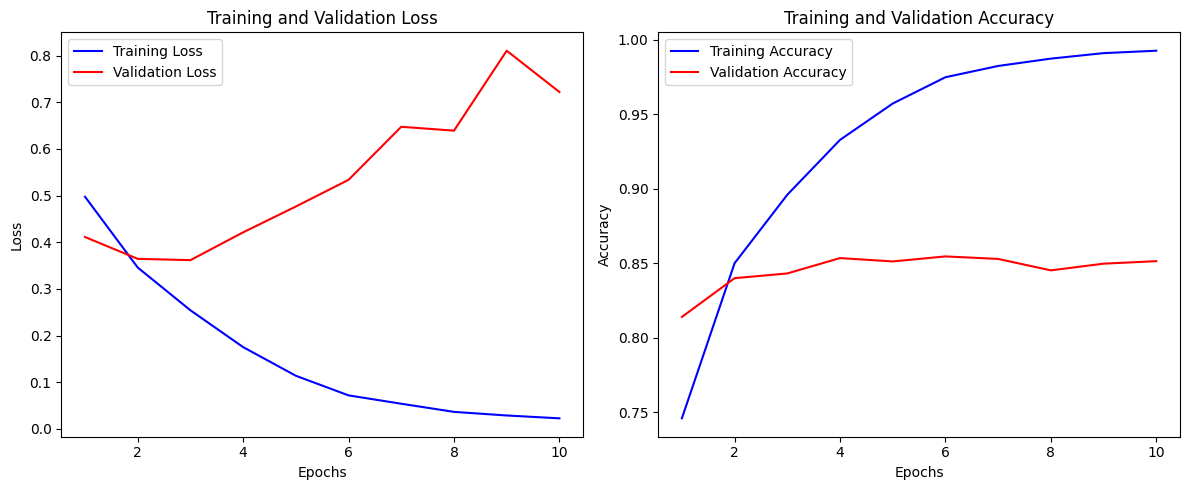

In [33]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, n_epochs+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, n_epochs+1), val_accs, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


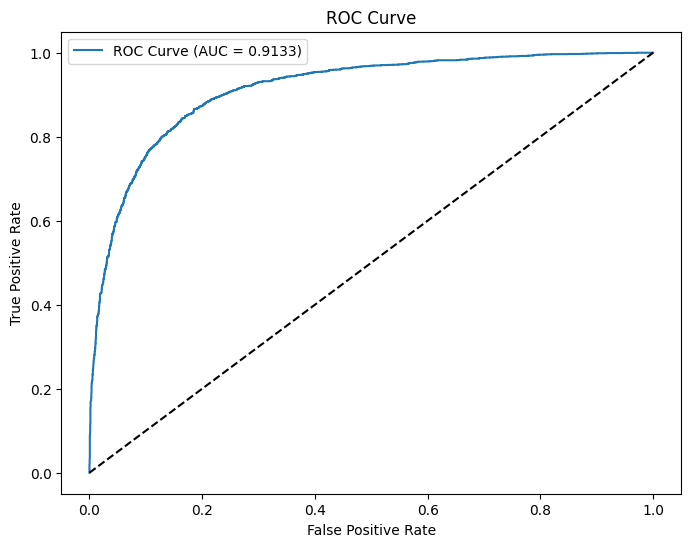

In [34]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_true, y_test_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_metrics["auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


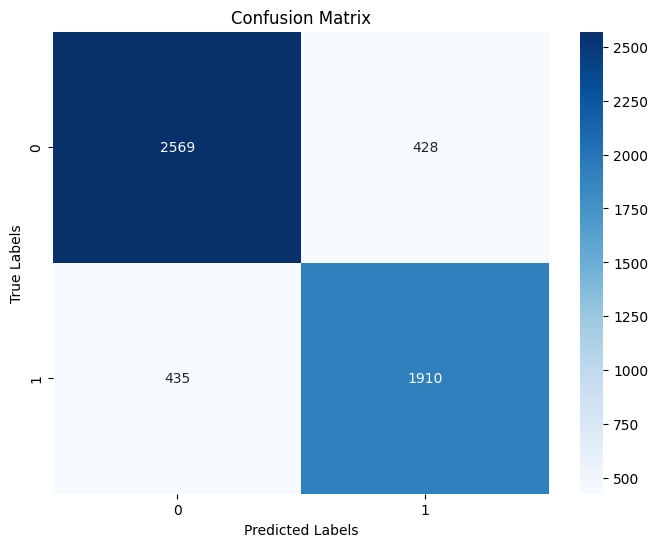

In [35]:
# Plot confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
# Additional analysis: visualize attention to words (simplified)
def get_word_importance(model, text_indices):
    # This is a simplified approach - in a real implementation,
    # you would use techniques like gradient-based attribution or attention mechanisms
    model.eval()
    text_tensor = torch.tensor([text_indices], dtype=torch.long).to(device)

    with torch.no_grad():
        # Get embeddings
        embedded = model.embedding(text_tensor).squeeze(0)
        # Take the L2 norm of each word embedding as a simple measure of importance
        importance = torch.norm(embedded, dim=1).cpu().numpy()

    return importance


In [37]:
# Get a sample from test set
sample_idx = 0
sample_text_indices = X_test[sample_idx]
sample_label = y_test[sample_idx]
sample_importance = get_word_importance(model, sample_text_indices)


In [38]:
# Convert indices back to words for visualization
sample_words = [vocab[idx] if idx < len(vocab) else '<UNK>' for idx in sample_text_indices if idx != 0]
sample_importance = sample_importance[:len(sample_words)]


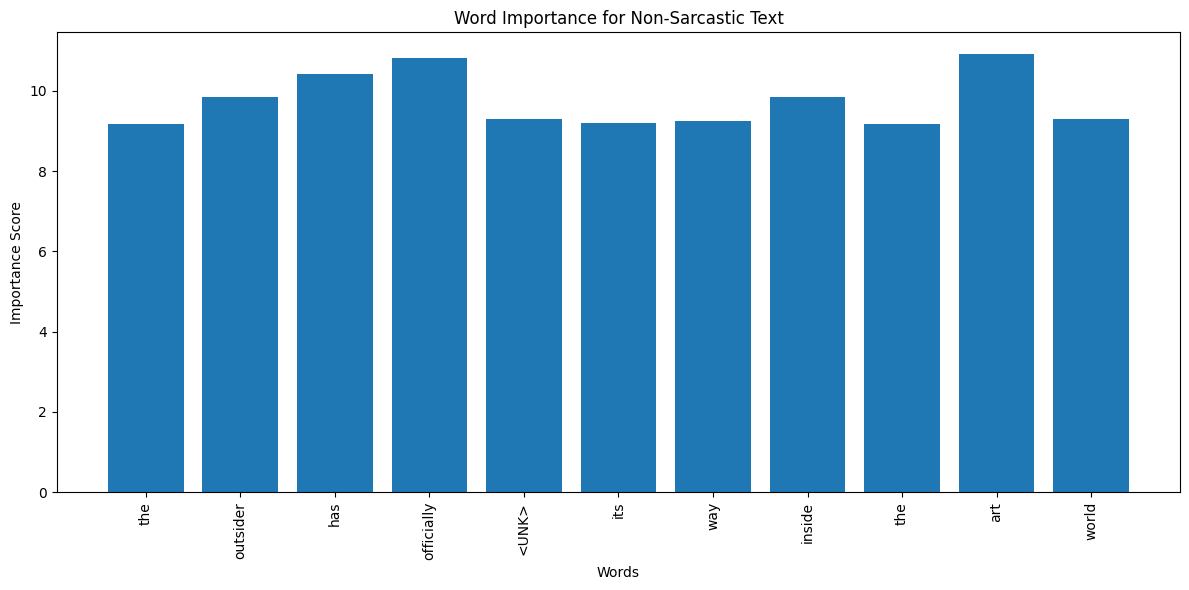


Model Architecture:
SarcasmRNN(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (rnn): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [39]:
# Plot word importance
plt.figure(figsize=(12, 6))
plt.bar(range(len(sample_words)), sample_importance)
plt.xticks(range(len(sample_words)), sample_words, rotation=90)
plt.xlabel('Words')
plt.ylabel('Importance Score')
plt.title(f'Word Importance for {"Sarcastic" if sample_label == 1 else "Non-Sarcastic"} Text')
plt.tight_layout()
plt.show()

print("\nModel Architecture:")
print(model)


In [40]:
# Output results directly as DataFrame instead of saving to CSV
results = {
    'Metric': list(test_metrics.keys()),
    'Value': list(test_metrics.values())
}
results_df = pd.DataFrame(results)
print("\nFinal Evaluation Results:")
print(results_df)



Final Evaluation Results:
      Metric     Value
0   accuracy  0.838450
1  precision  0.816938
2     recall  0.814499
3   f1_score  0.815716
4        auc  0.913349
